In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from data_frame import getDataFrame
from torchvision.utils import make_grid
from torch.utils.data.sampler import SubsetRandomSampler

In [9]:
# First 100 catagories
train_df = getDataFrame()
train_df = train_df[:5850]

In [10]:
train_df

,image_id,image_dir,category,genus
0,00000__001,../herbarium-2022-fgvc9/train_images/000/00/00...,0,0
1,00000__002,../herbarium-2022-fgvc9/train_images/000/00/00...,0,0
2,00000__003,../herbarium-2022-fgvc9/train_images/000/00/00...,0,0
3,00000__004,../herbarium-2022-fgvc9/train_images/000/00/00...,0,0
4,00000__005,../herbarium-2022-fgvc9/train_images/000/00/00...,0,0
...,...,...,...,...
5845,00100__026,../herbarium-2022-fgvc9/train_images/001/00/00...,100,21
5846,00100__027,../herbarium-2022-fgvc9/train_images/001/00/00...,100,21
5847,00100__029,../herbarium-2022-fgvc9/train_images/001/00/00...,100,21
5848,00100__030,../herbarium-2022-fgvc9/train_images/001/00/00...,100,21


In [13]:
BATCH = 10
EPOCHS = 20
LR = 0.002
IM_SIZE = 224

Transform = transforms.Compose(
    [
    transforms.ToTensor(),
    transforms.CenterCrop(666),
    transforms.Resize((IM_SIZE, IM_SIZE))
    ])

alter_img = transforms.Compose([
    transforms.ToTensor(),
    transforms.ColorJitter(brightness=.5, hue=.3),
    transforms.RandomAffine(degrees=(0, 180), translate=(0.1, 0.15)),
    transforms.CenterCrop(666),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.Resize((IM_SIZE, IM_SIZE))
])

In [14]:
def split_indices(n, val_pct=0.25, seed=99):
    n_val = int(val_pct*n)
    np.random.seed(seed)
    idxs = np.random.permutation(n)
    return idxs[n_val:], idxs[:n_val]

In [18]:
X_Train, Y_Train = train_df['image_dir'].values, train_df['genus'].values
train_indices, val_indices = split_indices(len(X_Train))


class GetData(Dataset):
    def __init__(self, FNames, Labels, Transform):
        self.fnames = FNames
        self.transform = Transform
        self.labels = Labels         
        
    def __len__(self):
        return len(self.fnames)

    # Returns the tensor image and corresponding label in a tuple
    def __getitem__(self, index):       
        #x = Image.open(self.fnames[index])
        x = cv2.imread(self.fnames[index])
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
        # mask = cv2.inRange(x, (165,155,115),(255,255,255))
        # x[mask>0] = (0,0,0)
        if "train" in self.fnames[index]:             
            return self.transform(x), self.labels[index]
        elif "test" in self.fnames[index]:            
            return self.transform(x), self.fnames[index]


                
trainset1 = GetData(X_Train[train_indices], Y_Train[train_indices], Transform)
trainset2 = GetData(X_Train[train_indices], Y_Train[train_indices], alter_img)
trainset3 = GetData(X_Train[train_indices], Y_Train[train_indices], alter_img)
trainset4 = GetData(X_Train[train_indices], Y_Train[train_indices], alter_img)

trainset = trainset1 + trainset2 + trainset3 + trainset4
valset = GetData(X_Train[val_indices], Y_Train[val_indices], Transform)

print(len(trainset) + len(valset))

19014


In [19]:
val_dl = DataLoader(valset, batch_size=BATCH, shuffle=True)
train_dl = DataLoader(trainset, batch_size=BATCH, shuffle=True)
print(len(val_dl), len(train_dl))
print(46*32+549*32)

147 1756
19040


images.shape: torch.Size([10, 3, 224, 224])


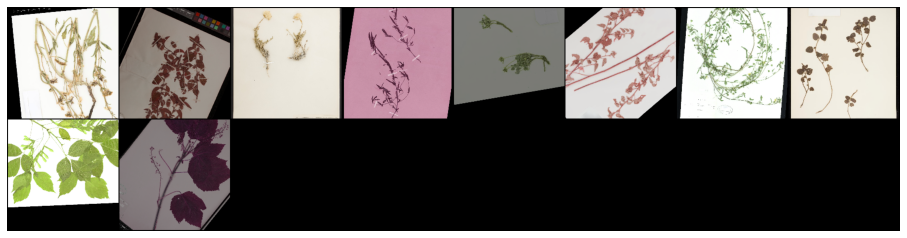

In [20]:
for images, _ in train_dl:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))
    break

In [21]:
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

device

device(type='mps')

In [22]:
N_Classes = train_df['genus'].nunique()

# for param in model.parameters():
#     param.requires_grad = False
    
model = torchvision.models.resnet34(pretrained = True)
fc_inputs = model.fc.in_features
model.fc = nn.Linear(fc_inputs, N_Classes)

model.to(device) 
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.classifier.parameters())
optimizer = torch.optim.Adam(model.parameters())    


/Users/terry/miniconda3/envs/torch-nightly/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/terry/miniconda3/envs/torch-nightly/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /Users/terry/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:09<00:00, 9.53MB/s]


In [23]:
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}

from tqdm import tqdm

def train(trainloader, model, criterion, optimizer, scaler, exp_lr_scheduler, device=torch.device(device)):
    train_acc = 0.0
    train_loss = 0.0
    model.train()
    for images, labels in tqdm(train_dl):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast(enabled=True):
            output = model(images)
            loss = criterion(output, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        acc = ((output.argmax(dim=1) == labels).float().mean())
        train_acc += acc
        train_loss += loss
        del output
        del loss
        
    # Decay LR by a factor of 0.1 every 2 epochs
    exp_lr_scheduler.step()
    return train_acc/len(trainloader), train_loss/len(trainloader)

def evaluate(testloader, model, criterion, device=torch.device(device)):
    eval_acc = 0.0
    eval_loss = 0.0
    model.eval()
    for images, labels in tqdm(val_dl):
        images = images.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            output = model(images)
            loss = criterion(output, labels)

        acc = ((output.argmax(dim=1) == labels).float().mean())
        eval_acc += acc
        eval_loss += loss
        del output
        del loss
  
    return eval_acc/len(testloader), eval_loss/len(testloader)

In [24]:
# Load model if found in CWD
from os.path import exists
path_to_file = './genus_resnet.pth'
file_exists = exists(path_to_file)
checkpoint = torch.load(path_to_file) if file_exists else None

if checkpoint:
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    print(f'Checkpoint has evaluation accuracy: {checkpoint["saved_accuracy"]}')
    

In [26]:
%%time
##%dirsrmal Training
scaler = torch.cuda.amp.GradScaler(enabled=True)
from torch.optim import lr_scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, 2, 0.1)
for epoch in range(EPOCHS):
    train_acc, train_loss = train(train_dl, model, criterion, optimizer, scaler, exp_lr_scheduler, device=device)
    eval_acc, eval_loss = evaluate(val_dl, model, criterion, device=device)

    # Saving the model information
    # torch.save(model, './processimg.pth')
    chkpt_info = {
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'saved_accuracy': eval_acc
    }
    torch.save(chkpt_info, './genus_resnet.pth')

    print("")
    print(f"Epoch {epoch + 1} | Train Acc: {train_acc*100} | Train Loss: {train_loss}")
    print(f"\t Val Acc: {eval_acc*100} | Val Loss: {eval_loss}")
    print("===="*8)

100%|██████████| 147/147 [00:16<00:00,  8.83it/s]



Epoch 1 | Train Acc: 77.65408325195312 | Train Loss: 0.6737951040267944
	 Val Acc: 84.35379791259766 | Val Loss: 0.5134307742118835


100%|██████████| 147/147 [00:16<00:00,  8.89it/s]



Epoch 2 | Train Acc: 78.1551284790039 | Train Loss: 0.6691616177558899
	 Val Acc: 84.14969635009766 | Val Loss: 0.5117565393447876


100%|██████████| 147/147 [00:16<00:00,  8.69it/s]



Epoch 3 | Train Acc: 77.23265838623047 | Train Loss: 0.6826309561729431
	 Val Acc: 85.30616760253906 | Val Loss: 0.49992820620536804


  3%|▎         | 52/1756 [00:34<18:41,  1.52it/s]


KeyboardInterrupt: 